In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import nibabel as nib
import matplotlib.pyplot as plt
# there was some problems for using import tensorflow as tf
# the way I found to fix it is the next two lines
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()

import tensorflow.keras
import numpy as np
import os

from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dense, GlobalAveragePooling3D
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling3D, Flatten, Dense, Conv3D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import zoom

#reduce the size of model weights
from tensorflow.keras import backend as K
K.set_floatx('float16')

W1203 20:19:33.852223 139623825946368 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:61: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        elif fullPath[-4:]=='.nii': # to avoid DS_Store or other system files
            allFiles.append(fullPath)
                
    return allFiles

In [3]:
def getImage( subject, directory ):

    epi_img = nib.load(subject + '.nii')
    epi_img_data = epi_img.get_fdata()
    
    v_min = epi_img_data.min(axis=(0, 1, 2), keepdims=True)
    v_max = epi_img_data.max(axis=(0, 1, 2), keepdims=True)
    epi_img_data = (epi_img_data - v_min)/(v_max - v_min)
        
    return epi_img_data

In [4]:
#extract m 5*5*5 patch from the images and put them in 'data' variable

#As we want to have 1000 patches from 100 MRI scanes
m = 100*10

#flatten patches
data = np.empty((m, 125))

#You may want to change the following line to the folder in which files are stores
directory = "./ADNI_Train/"
files = getListOfFiles(directory)
filenums = len(files)

# We will skip the patches that are all zero ('bad' patches)
num_added = 0

xdim = 68
ydim = 95
zdim = 79

#for loop will continue until m 'good' patches added to data
for index in range(m):
    if num_added >= m:
        #all data is complete now
        break
    random = np.random.randint(filenums)
    filename = files[random]
    subject = filename[:-4]
    image = getImage(subject=subject, directory=directory)
    
    n_i, n_j, n_k = image.shape
        
    if (n_i != xdim or n_j != ydim or n_k != zdim):
        #epi_img_data = cv2.resize(epi_img_data, (192, 192))
        #epi_img_data = epi_img_data[0:192,0:192,int(n_k/2)-80:int(n_k/2)+80]
            
        #resampling to make all MRI volumes the same dimensions
        image = zoom(image, (float(xdim/n_i), float(ydim/n_j), float(zdim/n_k)), order = 0)
    
    #about 10 patches from each image
    for i in range(5):
        n_i, n_j, n_k = image.shape
        rand = np.random.rand(3)
    
        corner_i = np.random.randint(n_i-5)
        corner_j = np.random.randint(n_j-5)
        corner_k = np.random.randint(n_k-5)
        patch = image[corner_i:corner_i+5,corner_j:corner_j+5,corner_k:corner_k+5]
        patch = patch.flatten()
        if np.linalg.norm(patch)!=0:
            data[num_added,:] = patch
#             print(data[index,:])
            num_added += 1
#             print('added', num_added)
            if num_added >= m:
                break
 
    
# Normalize data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:int(0.7*m)])
X_train = np.transpose(scaler.fit_transform(data[:int(0.7*m)]))
X_test =  np.transpose(scaler.fit_transform(data[int(0.7*m):]))
print(X_train.shape)

(125, 700)


In [6]:
#initializing parameters
n_inputs = 125
n_hidden = 150
n_outputs = 125

def initialize_parameters():
    
    
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [n_hidden,n_inputs])
    b1 = tf.get_variable("b1",[n_hidden,1],initializer=tf.zeros_initializer())
    b2 = tf.get_variable("b2",[n_outputs,1],initializer=tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "b2": b2}
    
    return parameters

In [7]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()

W1203 20:21:10.005472 139623825946368 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


#retrive parameters
W1 = parameters['W1']
b1 = parameters['b1']
b2 = parameters['b2']


learning_rate = 0.005

#sparsity hyper-parameter (It is not the best amount)
s=0.05

#penalty for sparsity (It is not the best amount)
beta = 0.5

#lambda, hyperparameter for weights (It is not the best amount)
lamb = 10

# Define architecture of autoencoder
X = tf.placeholder(tf.float32, shape=[n_inputs, None])
Z1 = tf.add(tf.matmul(W1,X),b1)

#regarding the paper first layer activation is sigmoid
hidden = tf.nn.sigmoid(Z1)

#regarding the paper second activation is identity
#regarding the paper the kernel for second activation is transpose of the first layer kernel
outputs = tf.add(tf.matmul(tf.transpose(W1),hidden),b2) 

# calculating kullback leibler loss
Shat = tf.reduce_mean(hidden,axis=1)
KL1 = s*(tf.log(s)-tf.log(Shat))+(1-s)*(tf.log(1-s)-tf.log(1-Shat))
KL = tf.math.reduce_sum(KL1)

#calculating norm loss
weight_L2_norm = tf.reduce_mean(tf.square(W1))

#calculating similarity loss
similoss = tf.reduce_mean(tf.reduce_sum(tf.square(outputs - X),axis=0))/2 #Is the axis=0 correct for reduce_sum?

# Define loss function and optimizer
loss = similoss + beta*KL + lamb*weight_L2_norm

#defining optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [14]:
a=1

In [15]:
a

1

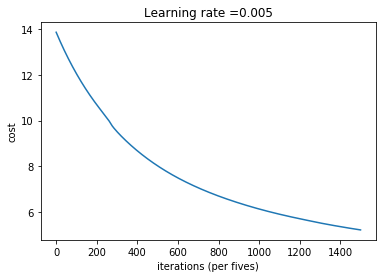

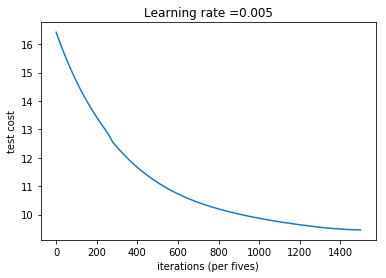

train_loss 5.2034254


In [10]:
#To rerun this you need to run the last three blocks also

#initialization
init = tf.global_variables_initializer()
n_iterations = 2000
costs = []
test_costs = []
random_costs = []

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        _ , cost = sess.run([training_op,loss],feed_dict={X:X_train})
        
        costs.append(cost)   
        test_loss=loss.eval(feed_dict={X:X_test})
        test_costs.append(test_loss)    
    # plot the cost
    plt.plot(np.squeeze(costs[500:]))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    # plot the test cost
    plt.plot(np.squeeze(test_costs[500:]))
    plt.ylabel('test cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()    
    final_train_loss=loss.eval(feed_dict={X:X_train})
    
    print('train_loss',final_train_loss)    
    similoss1 = similoss.eval(feed_dict={X:X_train})
    weight_L2_norm1 = weight_L2_norm.eval(feed_dict={X:X_train})
    KL1 = KL.eval(feed_dict={X:X_train})
    # lets save the parameters in a tensor variable, we may need trained parameters to use for the next part of DL
    #parameters include W1, b1, b2; however, we will just use W1 and b1
    parameters_tf = sess.run(parameters)    

In [11]:
#This is to check what is the contribution of each part in loss to adjust lamb and beta
print(similoss1)
print(weight_L2_norm1*lamb)
print(beta*KL1)
print(similoss1+weight_L2_norm1*lamb+beta*KL1)

2.1296473
0.47820180654525757
2.595576286315918
5.203425347805023


In [12]:
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)
    
    X_conv = Conv3D(150, (5, 5, 5), strides = (1, 1,1), name = 'conv0',data_format="channels_last", activation='sigmoid',trainable=False)(X_input)
    
    X_pool = MaxPooling3D(pool_size=(5,5,5), strides=None, data_format=None, name = 'pool')(X_conv) # it should be 5,5,5,
        
    X_conv2 = Conv3D(20,(5,5,15),strides = (1,1,1), name = 'conv2',data_format="channels_last", activation='sigmoid')(X_pool)
    
    X_pool_flat = Flatten()(X_conv2)
    
    X_dense = Dense(800, activation='sigmoid', name='fc')(X_pool_flat) # 100 should be 800 in the paper
    
    X_out = Dense(3, activation='softmax', name='out')(X_dense)
    
    model = Model(inputs = X_input, outputs = X_out, name='HappyModel')    
    
    
#     model.load_weights()
    
    return model

In [13]:
model1 = model ((68,95,79,1))
a = model1.get_weights()
#set weights of convolution layer
W1=parameters_tf['W1']
W1=W1.T.reshape(np.shape(a[0]))
# new_weights1 = []
# new_weights1.append(W1)
a[0] = W1
b1=parameters_tf['b1']
b1 = b1.reshape(np.shape(a[1]))
# new_weights1.append(b1)
a[1] = b1
model1.set_weights(a)
# trainable=False
#save model weights, note that we will only use the weights for the convolution layer
model1.save_weights('new_weights_1.h5')

In [32]:
a[0][0][0][0][0][0]

-0.3345

In [34]:
a = model1.get_weights()
print(a[0].shape,a[1].shape,a[2].shape,a[3].shape,a[4].shape,a[5].shape)

(5, 5, 5, 1, 150) (150,) (486000, 800) (800,) (800, 3) (3,)


Below is just a double check to make sure TF model properly transfered to Keras model;however, we do not nedd it for the project

In [16]:
def model_test(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)
    
    X = Conv3D(150, (5, 5, 5), strides = (1, 1,1), name = 'conv0',data_format="channels_last")(X_input)
    
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
        
    return model


In [35]:
#Using autoencoder to have 150 cubes of size 64*91*75 from the main input of size 68*95*79
files[1]
subject = filename[:-4]
image = getImage(subject=subject, directory=directory)
model_test1 = model_test ((68,95,79,1))
a=model_test1.get_weights()
W1=parameters['W1']
W1=W1.T.reshape(np.shape(a[0]))
new_weights1 = []
new_weights1.append(W1)
b1=parameters['b1']
b1 = b1.reshape(np.shape(a[1]))
new_weights1.append(b1)
model_test1.set_weights(new_weights1)
x_test = epi_img_data.reshape(1,68,95,79,1)
output = model_test1.predict(x_test)
outputKeras= output[0,0,0,0,:].reshape(150,1)
#now comparing that with tf output
a = x_test[0,30:35,30:35,30:35,0].flatten().reshape(125,1)
W1 = parameters['W1']
outputTF = np.matmul(W1,a)+b1.reshape(150,1)
print((output[0,30,30,30,:].reshape(150,1)-outputTF))

(1,)


ValueError: cannot reshape array of size 18750 into shape (1,)